# Explaining Event Data Clustering Results

This notebook conducts a comparative feasibility study using the BPI Challenge 2020 (Domestic Declarations) dataset to demonstrate the advantages of using declarative temporal constraints over standard feature encoding for explaining unsupervised learning results.

The analysis follows a four-step pipeline:

1. Clustering: The event log is first transformed into a feature matrix representing the presence or absence of activities (One-Hot Encoding). The HDBSCAN algorithm is applied to identify distinct behavioral clusters within the log, filtering out noise.
2. Constraint Mining: For each identified cluster, relevant declare constraints are loaded and filtered. The notebook specifically isolates constraints with a support greater than 99%—such as ChainResponse or Choice—to serve as a "mined" feature space that inherently captures the control-flow logic of the process.
3. Explanation Generation: The notebook employs the ClusterExplainPy library to generate rule-based explanations for the clusters using three distinct feature spaces:
   - Baseline: Standard One-Hot Encoding (activity presence).
   - Control: A declarative space restricted to Existence constraints (logically equivalent to the baseline).
   - Proposed: A rich feature space utilizing the mined, high-support declare constraints.
4. Evaluation: The quality of the generated explanations is evaluated based on Accuracy, Coverage, and Rule Length.

## Prerequisites

Before running this notebook, ensure you have:

1. **Event log data**: The input file `DomesticDeclarations.xes` must be present in `eventlogs/bpic_2020/`
   - Download from: [BPI Challenge 2020](https://doi.org/10.4121/uuid:52fb97d4-4588-43c9-9d04-3604d4613b51)
   
2. **Declare constraint discovery**: After running this notebook's clustering step, you need to run:
   - `miscellaneous/declare_discovery.ipynb` to generate `constraints_support_clusters.csv`, or simply use the provided file
   
3. **DFG visualizations** (optional): Run `miscellaneous/visualize_dfg.ipynb` to generate cluster directly follows graphs 


> **Note on Reproducibility**: The `ClusterExplainPy` library utilized in this notebook is a Python adaptation of `ClusterExplainR` and is currently not yet public released. For replication purposes, the original and fully-featured R implementation is open-source and available at [https://github.com/imperonas/clusterExplainR](https://github.com/imperonas/clusterExplainR).

### Loading Event Data

First we load the eventlog

In [1]:
from pathlib import Path

from src.eventlogs.utils import load_eventlog

# Load the event log
eventlog_path = Path("eventlogs", "bpic_2020", "DomesticDeclarations.xes")
event_log = load_eventlog(eventlog_path)

event_log

c:\Users\jamling\OneDrive - dab GmbH\projects\publications\xai-2026-declarative-feature-space\.conda\Lib\site-packages\pm4py\utils.py:992: UserWarning: Install the optional requirement `rustxes` to import/export files faster.
  warnings.warn("Install the optional requirement `rustxes` to import/export files faster.")


parsing log, completed traces ::   0%|          | 0/10500 [00:00<?, ?it/s]

,id,org:resource,concept:name,time:timestamp,org:role,case:id,case:concept:name,case:BudgetNumber,case:DeclarationNumber,case:Amount
0,st_step 86794_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-01-09 09:49:50+00:00,EMPLOYEE,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205
1,st_step 86793_0,STAFF MEMBER,Declaration FINAL_APPROVED by SUPERVISOR,2017-01-09 11:27:48+00:00,SUPERVISOR,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205
2,dd_declaration 86791_19,SYSTEM,Request Payment,2017-01-10 09:34:44+00:00,UNDEFINED,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205
3,dd_declaration 86791_20,SYSTEM,Payment Handled,2017-01-12 17:31:22+00:00,UNDEFINED,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205
4,st_step 86798_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-01-09 10:26:14+00:00,EMPLOYEE,declaration 86795,declaration 86795,budget 86566,declaration number 86796,182.464172
...,...,...,...,...,...,...,...,...,...,...
56432,st_step 138363_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2018-12-29 17:50:14+00:00,EMPLOYEE,declaration 138359,declaration 138359,budget 86566,declaration number 138360,190.404576
56433,st_step 138361_0,STAFF MEMBER,Declaration APPROVED by ADMINISTRATION,2018-12-29 17:56:13+00:00,ADMINISTRATION,declaration 138359,declaration 138359,budget 86566,declaration number 138360,190.404576
56434,st_step 138362_0,STAFF MEMBER,Declaration FINAL_APPROVED by SUPERVISOR,2019-01-03 08:55:52+00:00,SUPERVISOR,declaration 138359,declaration 138359,budget 86566,declaration number 138360,190.404576
56435,dd_declaration 138359_19,SYSTEM,Request Payment,2019-01-08 08:20:28+00:00,UNDEFINED,declaration 138359,declaration 138359,budget 86566,declaration number 138360,190.404576


This event log can be represented as a Directly Follows Graph:


![alt text](eventlogs/bpic_2020/dfg.png)


and we can inspect an individual trace, or event sequence

In [2]:
# convert to sequences

from src.eventlogs.utils import convert_eventLog_to_sequences

trace_sequences = convert_eventLog_to_sequences(event_log)
# Print the first entry from the trace_sequences dictionary
first_trace_id = next(iter(trace_sequences))
print(f"Trace ID: {first_trace_id}")
print(f"Sequence: \n\t{"\n\t -> ".join(trace_sequences[first_trace_id])}")

Trace ID: declaration 100000
Sequence: 
	Declaration SUBMITTED by EMPLOYEE
	 -> Declaration APPROVED by ADMINISTRATION
	 -> Declaration FINAL_APPROVED by SUPERVISOR
	 -> Request Payment
	 -> Payment Handled


### Event Sequence Clustering

To cluster the event sequences, we first transform the event log into a feature matrix by one-hot encoding the presence of activities in each case. We then apply HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) to identify clusters of cases with similar activity patterns, automatically determining the number of clusters while treating outliers as noise.

In [3]:
from src.eventlogs.utils import one_hot_encode_activity_presence

one_hot_encoded_df = one_hot_encode_activity_presence(event_log)
one_hot_encoded_df

,Declaration SUBMITTED by EMPLOYEE,Declaration FINAL_APPROVED by SUPERVISOR,Request Payment,Payment Handled,Declaration APPROVED by PRE_APPROVER,Declaration REJECTED by MISSING,Declaration REJECTED by PRE_APPROVER,Declaration REJECTED by EMPLOYEE,Declaration SAVED by EMPLOYEE,Declaration REJECTED by SUPERVISOR,Declaration APPROVED by ADMINISTRATION,Declaration APPROVED by BUDGET OWNER,Declaration FOR_APPROVAL by SUPERVISOR,Declaration REJECTED by ADMINISTRATION,Declaration FOR_APPROVAL by PRE_APPROVER,Declaration REJECTED by BUDGET OWNER,Declaration FOR_APPROVAL by ADMINISTRATION
declaration 100000,True,True,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False
declaration 100005,True,True,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False
declaration 100010,True,True,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False
declaration 100015,True,True,True,True,False,False,False,False,False,False,True,True,False,False,False,False,False
declaration 100021,True,True,True,True,False,False,False,False,False,False,True,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
declaration 99973,True,True,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False
declaration 99978,True,True,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False
declaration 99983,True,True,True,True,False,False,False,False,False,False,True,True,False,False,False,False,False
declaration 99989,True,True,True,True,False,False,False,False,False,False,True,True,False,False,False,False,False


c:\Users\jamling\OneDrive - dab GmbH\projects\publications\xai-2026-declarative-feature-space\.conda\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jamling\OneDrive - dab GmbH\projects\publications\xai-2026-declarative-feature-space\.conda\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


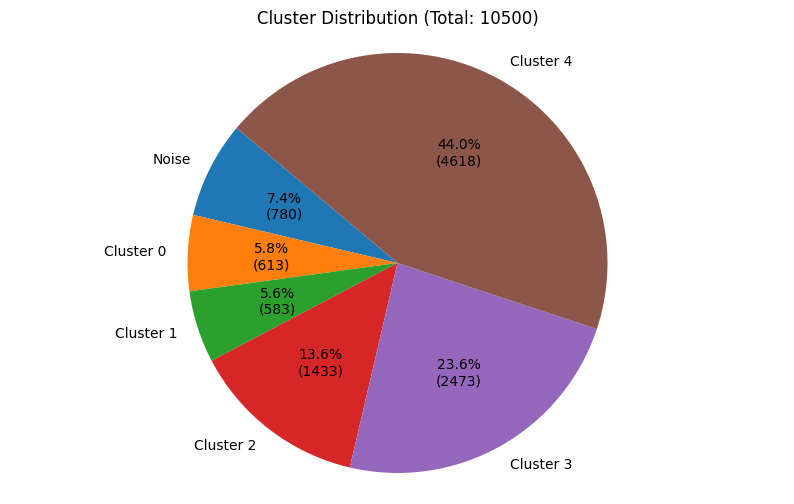

In [4]:
import hdbscan
import matplotlib.pyplot as plt

# use hdbscan to cluster the eventlog
# Fit HDBSCAN clustering on the one-hot encoded activity presence data

# Calculate 5% of total cases as minimum cluster size
five_percent_of_cases = int(event_log['case:id'].nunique() * 0.05)

clusterer = hdbscan.HDBSCAN(min_cluster_size=five_percent_of_cases)
cluster_labels = clusterer.fit_predict(one_hot_encoded_df)

# Add cluster labels to the dataframe
one_hot_encoded_df['cluster'] = cluster_labels


# Get cluster counts sorted by cluster ID
cluster_counts = one_hot_encoded_df['cluster'].value_counts().sort_index()

# Create labels, naming -1 as "Noise"
labels = [f"Cluster {i}" if i != -1 else "Noise" for i in cluster_counts.index]

# Define a function to formatting the label with both percentage and count
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return f'{pct:.1f}%\n({val})'
    return my_autopct

# Plot the pie chart
plt.figure(figsize=(10, 6))
plt.pie(cluster_counts, 
        labels=labels, 
        autopct=make_autopct(cluster_counts), 
        startangle=140)
plt.title(f"Cluster Distribution (Total: {len(one_hot_encoded_df)})")
plt.axis('equal')
plt.show()

The resulting clusters are as follows:
- Cluster 0: ![alt text](eventlogs/bpic_2020/dfg_cluster_0.png)
- Cluster 1: ![alt text](eventlogs/bpic_2020/dfg_cluster_1.png)
- Cluster 2: ![alt text](eventlogs/bpic_2020/dfg_cluster_2.png)
- Cluster 3: ![alt text](eventlogs/bpic_2020/dfg_cluster_3.png)
- Cluster 4: ![alt text](eventlogs/bpic_2020/dfg_cluster_4.png)

these visualizations can be generated as [shown here](./miscellaneous/visualize_dfg.ipynb)

To facilitate the subsequent mining of Declare constraints, we export the clustered event log to a file.

In [5]:
# Create a clustered event log by adding cluster information to the original event log
eventlog_clustered = event_log.copy()

# Create a mapping from case:id to cluster
case_to_cluster = one_hot_encoded_df['cluster'].to_dict()

# Add cluster column to the event log
eventlog_clustered['cluster'] = eventlog_clustered['case:id'].map(case_to_cluster)

# Write to file for DECLARE constraint mining
output_path = Path("eventlogs", "bpic_2020", "DomesticDeclarations_clustered.csv")
eventlog_clustered.to_csv(output_path, index=False)
print(f"Clustered event log saved to: {output_path}")

Clustered event log saved to: eventlogs\bpic_2020\DomesticDeclarations_clustered.csv


### Cluster Explanations

Next we compare cluster explanations using three feature spaces: 
1. One-Hot Encoding (OHE) of event type presence, 
2. a declarative equivalent using strictly `Existence` constraints, 
3. and a mined DECLARE feature space derived from high-support constraints within each cluster.

We mainly compare the rules generated by the explainers (ignoring the rules for the noise cluster) according to:

In [6]:
class SimpleRule:
    def __init__(self, cluster_id, rule:str, rule_length:int, accuracy: float, coverage:float):
        self.cluster_id = cluster_id
        self.rule = rule
        self.rule_length= rule_length
        self.accuracy = accuracy
        self.coverage = coverage
    
    def __str__(self):
        return f"Cluster {self.cluster_id} (Accuracy: {self.accuracy}, Coverage: {self.coverage}): \n {self.rule}\n\n"

#### ClusterExplainR on the original OHE


In [7]:
# use the clusterExplainR python implementation to explain the clusters
from ClusterExplainPy import ClusterExplainPy

explainer_ohe = ClusterExplainPy(one_hot_encoded_df, categorical_columns=one_hot_encoded_df.columns.drop('cluster').tolist(), numerical_columns=[], cluster_column='cluster')

explanation_ohe = explainer_ohe.explain(generate_rules=True, top_n_features=3)

# and bring rules in format for comparison as well as print them
rules_ohe = {}
for cluster, rule in explanation_ohe.local_explanations.items():
    if cluster == -1:
        continue
    accuracy = rule.local_rule_metrics.loc[rule.local_rule_metrics.index.max()].Accuracy
    coverage = rule.local_rule_metrics.loc[rule.local_rule_metrics.index.max()].Coverage
    rule_length = len(rule.local_rule_metrics.index)
    rules_ohe[cluster] = SimpleRule(cluster,str(rule.local_rule), rule_length, accuracy, coverage)
    print(rules_ohe[cluster])

Cluster 4 (Accuracy: 1.0, Coverage: 1.0): 
 (Declaration APPROVED by BUDGET OWNER is False 
 AND Declaration APPROVED by ADMINISTRATION is True 
 AND Declaration REJECTED by EMPLOYEE is False 
 AND Request Payment is True 
 AND Declaration REJECTED by MISSING is False)


Cluster 3 (Accuracy: 1.0, Coverage: 1.0): 
 (Declaration APPROVED by BUDGET OWNER is True 
 AND Declaration REJECTED by EMPLOYEE is False 
 AND Request Payment is True 
 AND Declaration APPROVED by PRE_APPROVER is False)


Cluster 0 (Accuracy: 0.9997142857142857, Coverage: 0.9951060358890701): 
 (Declaration REJECTED by EMPLOYEE is True 
 AND Declaration APPROVED by ADMINISTRATION is True 
 AND Declaration FINAL_APPROVED by SUPERVISOR is True 
 AND Declaration REJECTED by PRE_APPROVER is False 
 AND Declaration REJECTED by MISSING is False 
 AND Declaration FOR_APPROVAL by ADMINISTRATION is False 
 AND Declaration REJECTED by ADMINISTRATION is True 
 AND Declaration REJECTED by SUPERVISOR is False 
 AND Declaration REJ

#### ClusterExplainR on the equivalent Declare Feature Space


we can represent the same feature space used for clustering (one hot encoding of activities) using the `Existence` Declare Constraint 

In [8]:
from src.declare.declare_feature_space import DeclarativeFeatureSpace
from src.declare.constraints import Existence

simple_declarative_feature_space = DeclarativeFeatureSpace(
    constraints= [Existence(x) for x in event_log["concept:name"].unique()]
)

declare_rep = simple_declarative_feature_space.to_interpretable_instance(trace_sequences[first_trace_id])
simple_declarative_feature_space.represent_instance(declare_rep)

'Existence(Declaration SUBMITTED by EMPLOYEE), Existence(Declaration FINAL_APPROVED by SUPERVISOR), Existence(Request Payment), Existence(Payment Handled), NOT Existence(Declaration APPROVED by PRE_APPROVER), NOT Existence(Declaration REJECTED by MISSING), NOT Existence(Declaration REJECTED by PRE_APPROVER), NOT Existence(Declaration REJECTED by EMPLOYEE), NOT Existence(Declaration SAVED by EMPLOYEE), NOT Existence(Declaration REJECTED by SUPERVISOR), Existence(Declaration APPROVED by ADMINISTRATION), NOT Existence(Declaration APPROVED by BUDGET OWNER), NOT Existence(Declaration FOR_APPROVAL by SUPERVISOR), NOT Existence(Declaration REJECTED by ADMINISTRATION), NOT Existence(Declaration FOR_APPROVAL by PRE_APPROVER), NOT Existence(Declaration REJECTED by BUDGET OWNER), NOT Existence(Declaration FOR_APPROVAL by ADMINISTRATION)'

and generate the representation using that Feature Space

In [9]:
import numpy as np

# convert the complete setO
# convert the complete set of trace sequences to a numpy matrix
declare_rep_all = simple_declarative_feature_space.to_interpretable_set(trace_sequences.values())
df = simple_declarative_feature_space.represent_matrix(declare_rep_all)
df['case:id'] = trace_sequences.keys()
df['cluster'] = df['case:id'].map(one_hot_encoded_df['cluster'])
df


,Existence(Declaration SUBMITTED by EMPLOYEE),Existence(Declaration FINAL_APPROVED by SUPERVISOR),Existence(Request Payment),Existence(Payment Handled),Existence(Declaration APPROVED by PRE_APPROVER),Existence(Declaration REJECTED by MISSING),Existence(Declaration REJECTED by PRE_APPROVER),Existence(Declaration REJECTED by EMPLOYEE),Existence(Declaration SAVED by EMPLOYEE),Existence(Declaration REJECTED by SUPERVISOR),Existence(Declaration APPROVED by ADMINISTRATION),Existence(Declaration APPROVED by BUDGET OWNER),Existence(Declaration FOR_APPROVAL by SUPERVISOR),Existence(Declaration REJECTED by ADMINISTRATION),Existence(Declaration FOR_APPROVAL by PRE_APPROVER),Existence(Declaration REJECTED by BUDGET OWNER),Existence(Declaration FOR_APPROVAL by ADMINISTRATION),case:id,cluster
0,True,True,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,declaration 100000,4
1,True,True,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,declaration 100005,4
2,True,True,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,declaration 100010,4
3,True,True,True,True,False,False,False,False,False,False,True,True,False,False,False,False,False,declaration 100015,3
4,True,True,True,True,False,False,False,False,False,False,True,True,False,False,False,False,False,declaration 100021,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10495,True,True,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,declaration 99973,4
10496,True,True,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,declaration 99978,4
10497,True,True,True,True,False,False,False,False,False,False,True,True,False,False,False,False,False,declaration 99983,3
10498,True,True,True,True,False,False,False,False,False,False,True,True,False,False,False,False,False,declaration 99989,3


finally we can create cluster explanation rules based on the Declare equivalent feature space

In [10]:
# use the clusterExplainR to explain the outcomes of the clustering using equivalent declare feature space
explainer_declare_equivalent = ClusterExplainPy(df, categorical_columns=df.columns.drop('cluster').drop('case:id').tolist(), numerical_columns=[], cluster_column='cluster')

explanation_de = explainer_declare_equivalent.explain(generate_rules=True, top_n_features=3)

rules_de = {}
for cluster, rule in explanation_de.local_explanations.items():
    if cluster == -1:
        continue
    accuracy = rule.local_rule_metrics.loc[rule.local_rule_metrics.index.max()].Accuracy
    coverage = rule.local_rule_metrics.loc[rule.local_rule_metrics.index.max()].Coverage
    rule_length = len(rule.local_rule_metrics.index)
    rules_de[cluster] = SimpleRule(cluster,str(rule.local_rule), rule_length, accuracy, coverage)
    print(rules_de[cluster])


Cluster 4 (Accuracy: 1.0, Coverage: 1.0): 
 (Existence(Declaration APPROVED by BUDGET OWNER) is False 
 AND Existence(Declaration APPROVED by ADMINISTRATION) is True 
 AND Existence(Declaration REJECTED by EMPLOYEE) is False 
 AND Existence(Request Payment) is True 
 AND Existence(Declaration REJECTED by MISSING) is False)


Cluster 3 (Accuracy: 1.0, Coverage: 1.0): 
 (Existence(Declaration APPROVED by BUDGET OWNER) is True 
 AND Existence(Declaration REJECTED by EMPLOYEE) is False 
 AND Existence(Request Payment) is True 
 AND Existence(Declaration APPROVED by PRE_APPROVER) is False)


Cluster 0 (Accuracy: 0.9997142857142857, Coverage: 0.9951060358890701): 
 (Existence(Declaration REJECTED by EMPLOYEE) is True 
 AND Existence(Declaration APPROVED by ADMINISTRATION) is True 
 AND Existence(Declaration FINAL_APPROVED by SUPERVISOR) is True 
 AND Existence(Declaration REJECTED by PRE_APPROVER) is False 
 AND Existence(Declaration REJECTED by MISSING) is False 
 AND Existence(Declaration 

#### ClusterExplainR on a mined Declare Feature Space

In order to select appropriate declare constraints we mine the most important Declare constraints per Cluster and use the most prone one as our explanation space.

Mining is shown [here](./miscellaneous/declare_discovery.ipynb), and from the mined constraints we only use those with a support $>0.99$

In [11]:
# Load discovered DECLARE constraints from declare_discovery.ipynb output
import pandas as pd
import os

constraints_path = os.path.join("eventlogs", "bpic_2020", "constraints_support_clusters.csv")
discovered_declare_constraints = pd.read_csv(constraints_path)

# Filter on DECLARE constraints based on support
filtered_constraints = discovered_declare_constraints[discovered_declare_constraints['Support'] > 0.99]
filtered_constraints

,Constraint,Support,cluster
0,Absence2[Payment Handled] | |,1.000000,-1
1,Absence2[Declaration SAVED by EMPLOYEE] | |,1.000000,-1
2,Absence2[Request Payment] | |,1.000000,-1
3,Absence2[Declaration REJECTED by BUDGET OWNER]...,0.998718,-1
4,Absence2[Declaration REJECTED by PRE_APPROVER]...,0.993590,-1
...,...,...,...
2014,Alternate Precedence[Declaration FINAL_APPROVE...,1.000000,4
2015,Chain Precedence[Declaration FINAL_APPROVED by...,1.000000,4
2016,"Not Response[Request Payment, Declaration FINA...",1.000000,4
2017,"Not Precedence[Request Payment, Declaration FI...",1.000000,4


we cast the mined constraints into our implementation of declare constraints 

In [12]:
from src.declare.constraints import *
import re
def to_constraint(constraints:list) -> list[DeclareConstraint]:
    result = []
    # Map constraint names to constraint classes
    constraint_map = {
                'Existence1': Existence,
                'Existence2': None,
                'Exactly1': None,
                'Exactly2': None,
                'Absence1': Absence,
                'Absence2': None,
                'Exactly': None,
                'Init': Init,
                'End': End,
                'Response': Response,
                'Precedence': Precedence,
                'Chain Response': ChainResponse,
                'Chain Precedence': ChainPrecedence,
                'Alternate Response': AlternateResponse,
                'Alternate Precedence': AlternatePrecedence,
                'Responded Existence': RespondedExistence,
                'Exclusive Choice': ExclusiveChoice,
                'Choice': Choice
            }
    for constraint_str in constraints:
        if constraint_str.startswith('Not'):
            continue 

        # Parse the constraint string using regex
        # Pattern: constraint_name[activity_1, activity_2]||
        match = re.match(r'((?:NOT\s+)?[\w\s]+)\[([^\]]+)\]\s*\|\s*\|', constraint_str)
        
        if match:
            constraint_name = match.group(1).strip()
            activities = match.group(2).strip()
            
            # Split activities by comma
            activity_parts = [a for a in activities.split(',')]
            
            
            if constraint_name in constraint_map:
                constraint_class = constraint_map[constraint_name]
                # Skip constraints associated with None in map
                if constraint_class is None:
                    continue
                # Create constraint instance based on number of activities
                constraint = None
                if len(activity_parts) == 1:
                    
                    constraint = constraint_class(activity_parts[0])
                elif len(activity_parts) == 2:
                    constraint = constraint_class(activity_parts[0], activity_parts[1])
                
                # use string compare to ensure no constraint is added multiple times
                if not str(constraint)in [str(c) for c in result]:
                    result.append(constraint)

            else:
                print(f"{constraint_name} not in map")
        else:
            print(f"\t{constraint_str} not matched")
    
    return result

mined_constraints = to_constraint(filtered_constraints['Constraint'])
for c in mined_constraints:
    print(c)

print(f"\n------------------\nMined {len(mined_constraints)} unique constraints")

Existence(Request Payment)
AlternateResponse(Declaration REJECTED by EMPLOYEE,  Declaration SUBMITTED by EMPLOYEE)
Response(Declaration REJECTED by EMPLOYEE,  Declaration SUBMITTED by EMPLOYEE)
RespondedExistence(Declaration SUBMITTED by EMPLOYEE,  Declaration REJECTED by EMPLOYEE)
Choice(Declaration SUBMITTED by EMPLOYEE,  Declaration REJECTED by EMPLOYEE)
Choice(Declaration REJECTED by EMPLOYEE,  Declaration SUBMITTED by EMPLOYEE)
Choice(Payment Handled,  Declaration APPROVED by BUDGET OWNER)
Choice(Declaration APPROVED by BUDGET OWNER,  Payment Handled)
Choice(Payment Handled,  Declaration REJECTED by ADMINISTRATION)
ChainResponse(Declaration REJECTED by EMPLOYEE,  Declaration SUBMITTED by EMPLOYEE)
Precedence(Declaration SUBMITTED by EMPLOYEE,  Declaration REJECTED by EMPLOYEE)
AlternatePrecedence(Declaration SUBMITTED by EMPLOYEE,  Declaration REJECTED by EMPLOYEE)
Choice(Declaration APPROVED by ADMINISTRATION,  Declaration SUBMITTED by EMPLOYEE)
Choice(Declaration SUBMITTED by EM

and create a representation of our event sequences within the mined declarative feature space.

In [13]:

extended_declarative_feature_space = DeclarativeFeatureSpace(
    constraints= mined_constraints
)

#declare_rep_extended = extended_declarative_feature_space.to_interpretable_instance(trace_sequences[first_trace_id])
#extended_declarative_feature_space.represent_instance(declare_rep_extended)

declare_rep_all_extended = extended_declarative_feature_space.to_interpretable_set(trace_sequences.values())
df_ext = extended_declarative_feature_space.represent_matrix(declare_rep_all_extended)
df_ext['case:id'] = trace_sequences.keys()
df_ext['cluster'] = df_ext['case:id'].map(one_hot_encoded_df['cluster'])
df_ext

,Existence(Request Payment),"AlternateResponse(Declaration REJECTED by EMPLOYEE, Declaration SUBMITTED by EMPLOYEE)","Response(Declaration REJECTED by EMPLOYEE, Declaration SUBMITTED by EMPLOYEE)","RespondedExistence(Declaration SUBMITTED by EMPLOYEE, Declaration REJECTED by EMPLOYEE)","Choice(Declaration SUBMITTED by EMPLOYEE, Declaration REJECTED by EMPLOYEE)","Choice(Declaration REJECTED by EMPLOYEE, Declaration SUBMITTED by EMPLOYEE)","Choice(Payment Handled, Declaration APPROVED by BUDGET OWNER)","Choice(Declaration APPROVED by BUDGET OWNER, Payment Handled)","Choice(Payment Handled, Declaration REJECTED by ADMINISTRATION)","ChainResponse(Declaration REJECTED by EMPLOYEE, Declaration SUBMITTED by EMPLOYEE)",...,"RespondedExistence(Request Payment, Declaration APPROVED by BUDGET OWNER)","RespondedExistence(Declaration APPROVED by BUDGET OWNER, Request Payment)","Response(Declaration APPROVED by BUDGET OWNER, Request Payment)","AlternateResponse(Declaration APPROVED by BUDGET OWNER, Request Payment)","Precedence(Declaration APPROVED by BUDGET OWNER, Request Payment)","AlternatePrecedence(Declaration APPROVED by BUDGET OWNER, Request Payment)","ChainResponse(Declaration APPROVED by ADMINISTRATION, Declaration FINAL_APPROVED by SUPERVISOR)","ChainPrecedence(Declaration APPROVED by ADMINISTRATION, Declaration FINAL_APPROVED by SUPERVISOR)",case:id,cluster
0,True,True,True,True,True,False,True,False,True,True,...,True,True,True,True,True,True,False,True,declaration 100000,4
1,True,True,True,True,True,False,True,False,True,True,...,True,True,True,True,True,True,False,True,declaration 100005,4
2,True,True,True,True,True,False,True,False,True,True,...,True,True,True,True,True,True,False,True,declaration 100010,4
3,True,True,True,True,True,False,True,True,True,True,...,True,True,False,False,True,True,False,True,declaration 100015,3
4,True,True,True,True,True,False,True,True,True,True,...,True,True,False,False,True,True,False,True,declaration 100021,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10495,True,True,True,True,True,False,True,False,True,True,...,True,True,True,True,True,True,False,True,declaration 99973,4
10496,True,True,True,True,True,False,True,False,True,True,...,True,True,True,True,True,True,False,True,declaration 99978,4
10497,True,True,True,True,True,False,True,True,True,True,...,True,True,False,False,True,True,False,True,declaration 99983,3
10498,True,True,True,True,True,False,True,True,True,True,...,True,True,False,False,True,True,False,True,declaration 99989,3


In [14]:
explainer_declare_extended = ClusterExplainPy(df_ext, categorical_columns=df_ext.columns.drop(['cluster','case:id']).tolist(), numerical_columns=[], cluster_column='cluster')

explanation_de_extended = explainer_declare_extended.explain(generate_rules=True, top_n_features=3)

rules_de_extended = {}
for cluster, rule in explanation_de_extended.local_explanations.items():
    if cluster == -1:
        continue
    accuracy = rule.local_rule_metrics.loc[rule.local_rule_metrics.index.max()].Accuracy
    coverage = rule.local_rule_metrics.loc[rule.local_rule_metrics.index.max()].Coverage
    rule_length = len(rule.local_rule_metrics.index)
    rules_de_extended[cluster] = SimpleRule(cluster,str(rule.local_rule), rule_length, accuracy, coverage)
    print(rules_de_extended[cluster])

Cluster 4 (Accuracy: 0.9999047619047619, Coverage: 1.0): 
 (AlternateResponse(Declaration APPROVED by BUDGET OWNER,  Request Payment) is True 
 AND ChainResponse(Declaration APPROVED by ADMINISTRATION,  Declaration FINAL_APPROVED by SUPERVISOR) is False 
 AND AlternateResponse(Declaration REJECTED by EMPLOYEE,  Declaration SUBMITTED by EMPLOYEE) is True 
 AND Existence(Request Payment) is True)


Cluster 3 (Accuracy: 1.0, Coverage: 1.0): 
 (AlternateResponse(Declaration APPROVED by BUDGET OWNER,  Request Payment) is False 
 AND AlternateResponse(Declaration REJECTED by EMPLOYEE,  Declaration SUBMITTED by EMPLOYEE) is True 
 AND Existence(Request Payment) is True 
 AND Choice(Declaration APPROVED by PRE_APPROVER,  Request Payment) is False)


Cluster 0 (Accuracy: 0.9974285714285714, Coverage: 0.9967373572593801): 
 (AlternateResponse(Declaration REJECTED by EMPLOYEE,  Declaration SUBMITTED by EMPLOYEE) is False 
 AND ChainResponse(Declaration APPROVED by ADMINISTRATION,  Declaration FIN

### Evaluation -- Comparing the generated rules

Finally, we compare the quality of the generated rules from the three different feature spaces based on the following metrics:

- **Coverage**: The proportion of instances within the target cluster that the rule correctly identifies.
- **Accuracy**: The proportion of all instances (both in the target cluster and outside of it) that the rule correctly classifies.
- **Rule Length**: The number of conditions that make up the rule. Shorter rules are generally considered more interpretable.

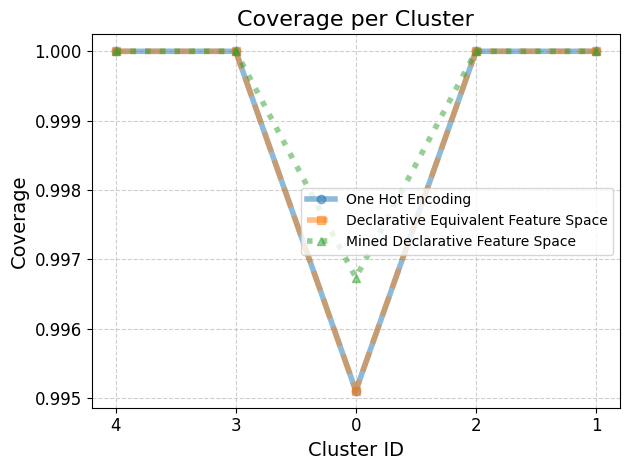

In [15]:
import matplotlib.pyplot as plt

rule_sequences = [rules_ohe, rules_de, rules_de_extended]
labels = ["One Hot Encoding", "Declarative Equivalent Feature Space", "Mined Declarative Feature Space"]
MARKERS = ["o", "s", "^"]
LINESTYLES = ["-", "--", ":"]

plt.figure()

for rules, label, marker, linestyle in zip(rule_sequences, labels, MARKERS, LINESTYLES):
    clusters = [str(k) for k in rules.keys()]
    values = [r.coverage for r in rules.values()]

    plt.plot(clusters, values, marker=marker, label=label, linestyle=linestyle, alpha=0.5, linewidth=4)

plt.xlabel("Cluster ID", fontsize=14)
plt.ylabel("Coverage", fontsize=14)
plt.title(f"Coverage per Cluster", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
#plt.savefig('../img/bpic_rules_coverage.pdf', format='pdf')
plt.show()


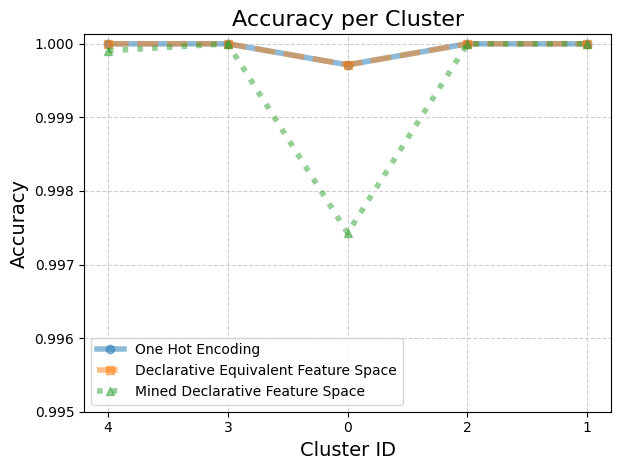

In [16]:

plt.figure()

for rules, label, marker, linestyle in zip(rule_sequences, labels, MARKERS, LINESTYLES):
    clusters = [str(k) for k in rules.keys()]
    values = [r.accuracy for r in rules.values()]

    plt.plot(clusters, values, marker=marker, label=label, linestyle=linestyle, alpha=0.5, linewidth=4)

plt.xlabel("Cluster ID", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title(f"Accuracy per Cluster", fontsize=16)
plt.legend()#(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.ylim(0.995, None)
#plt.savefig('../img/bpic_rules_accuracy.pdf', format='pdf')
plt.show()

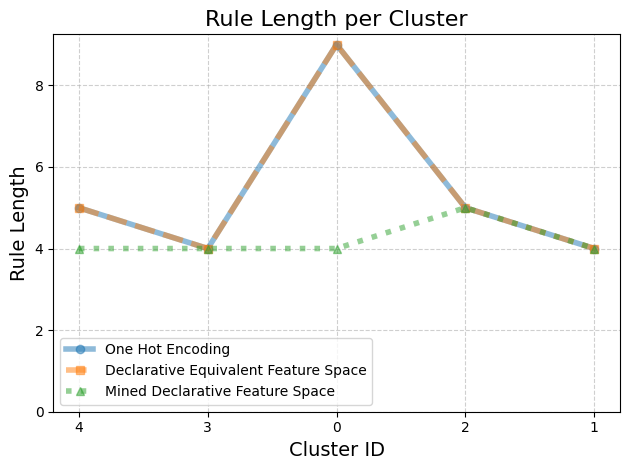

In [17]:

plt.figure()

for rules, label, marker, linestyle in zip(rule_sequences, labels, MARKERS, LINESTYLES):
    clusters = [str(k) for k in rules.keys()]
    values = [r.rule_length for r in rules.values()]

    plt.plot(clusters, values, marker=marker, label=label, linestyle=linestyle, alpha=0.5, linewidth=4)

plt.xlabel("Cluster ID", fontsize=14)
plt.ylabel("Rule Length", fontsize=14)
plt.title(f"Rule Length per Cluster", fontsize=16)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.ylim(0, None)
#plt.savefig('../img/bpic_rules_length.pdf', format='pdf')
plt.show()

### Example

next you can visualize the individual clusters together with the created rules

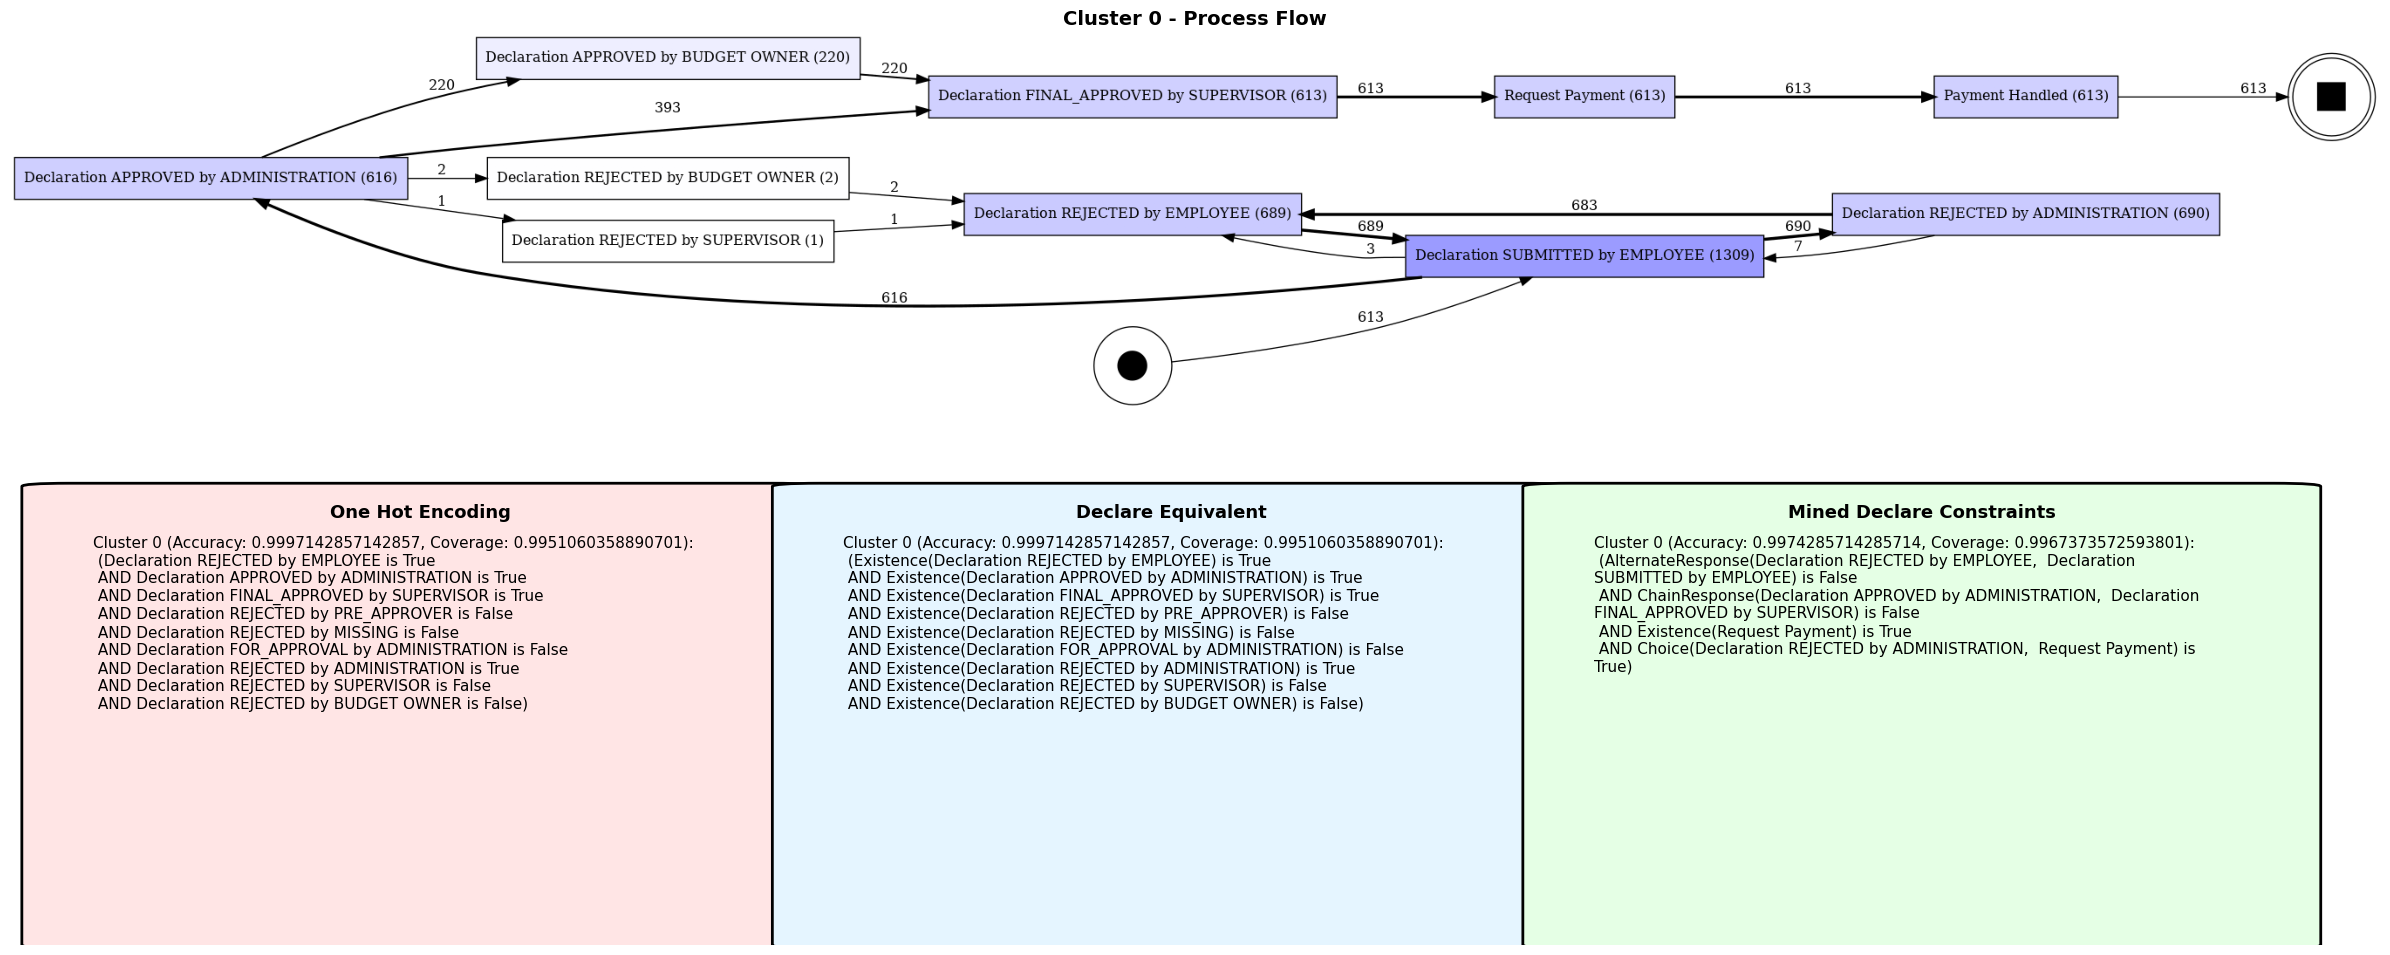

In [18]:
from matplotlib import pyplot as plt
from matplotlib.patches import FancyBboxPatch
from textwrap import fill
import matplotlib.image as mpimg

# Select a cluster to visualize (e.g., cluster 0)
CLUSTER_ID = 0

labels = ['One Hot Encoding', 'Declare Equivalent', 'Mined Declare Constraints']

# Get the rules for the selected cluster
rule_texts = [
   str(rules_ohe[CLUSTER_ID]),
   str(rules_de[CLUSTER_ID]),
   str(rules_de_extended[CLUSTER_ID])
]

# Calculate maximum text length for width adjustment
max_text_length = max(len(text) for text in rule_texts)
# Adjust figure width based on text length (with a minimum and scaling factor)
fig_width = min(max(12, max_text_length * 0.15), 24)

# Create figure with custom layout
fig = plt.figure(figsize=(fig_width, 10))

# Top subplot for the image
ax_img = plt.subplot2grid((2, 1), (0, 0), rowspan=1)
img = mpimg.imread(f"eventlogs/bpic_2020/dfg_cluster_{CLUSTER_ID}.png")
ax_img.imshow(img)
ax_img.axis('off')
ax_img.set_title(f"Cluster {CLUSTER_ID} - Process Flow", fontsize=14, fontweight='bold')

# Bottom subplot for the text boxes
ax_text = plt.subplot2grid((2, 1), (1, 0), rowspan=1)
ax_text.axis('off')
ax_text.set_xlim(0, 1)
ax_text.set_ylim(0, 3)

# Define colors for each explanation type
colors = ['#FFE5E5', '#E5F5FF', '#E5FFE5']

# Calculate box width based on number of boxes
num_boxes = len(labels)
box_width = 0.95 / num_boxes - 0.02
spacing = 0.02

# Add text boxes for each rule
for idx, (label, color, rule_text) in enumerate(zip(labels, colors, rule_texts)):
   x_pos = 0.025 + idx * (box_width + spacing)
   
   # Create fancy box
   box = FancyBboxPatch((x_pos, 0), box_width, 2.8, 
                    boxstyle="round,pad=0.02", 
                    edgecolor='black', 
                    facecolor=color, 
                    linewidth=2)
   ax_text.add_patch(box)
   
   # Add title
   ax_text.text(x_pos + box_width/2, 2.7, label, 
             fontsize=13, fontweight='bold', 
             ha='center', va='top')
   
   # Add rule text
   # Wrap text to fit within the box
   # Simple approach: add newline when line gets too long
   max_chars_per_line = int(box_width * 250)  # Adjust multiplier as needed
   lines = []
   for line in rule_text.split('\n'):
       if len(line) <= max_chars_per_line:
           lines.append(line)
       else:
           # Break long lines at spaces
           words = line.split(' ')
           current_line = ''
           for word in words:
               if len(current_line) + len(word) + 1 <= max_chars_per_line:
                   current_line += word + ' '
               else:
                   if current_line:
                       lines.append(current_line.rstrip())
                   current_line = word + ' '
           if current_line:
               lines.append(current_line.rstrip())
   wrapped_text = '\n'.join(lines)
   
   ax_text.text(x_pos + 0.01, 2.5, wrapped_text, 
             fontsize=11, ha='left', va='top',
             verticalalignment='top')

plt.tight_layout()
plt.show()

### Conclusion

This notebook demonstrates that clustering an event log and explaining the resulting clusters can yield more insightful and concise explanations when using a declarative feature space compared to simple one-hot encoding of activity presence.

We compared three approaches for generating cluster explanations:

1. One-Hot Encoding (OHE): Based on the presence or absence of activities.
2. Declarative Equivalent: Using only Existence constraints, which mirrors the OHE approach.
3. Mined Declare Feature Space: A richer feature space derived from high-support DECLARE constraints mined from each cluster.

The results show that while all three methods produce rules with high accuracy and coverage, the mined declarative feature space offers a significant advantage in terms of interpretability and conciseness. The rules generated from the mined feature space are shorter and more expressive, capturing complex temporal and logical relationships between activities in a single constraint. For example, a rule for Cluster 0 based on the mined feature space required only four conditions, whereas the equivalent OHE-based rule needed nine.

In conclusion, leveraging a mined declarative feature space for explaining event data clusters simplifies the resulting rules, making them more meaningful for process analysts without sacrificing explanatory power. This highlights the value of using domain-specific, high-level feature representations for generating more intuitive and actionable insights in process mining.